# Biology & Omics Showcase — Single-DataFrame Workflow

Every example starts from **one flat `pd.DataFrame`** containing both heatmap
values and row-level metadata.

- **Simple annotations** (categorical, bar): use `from_dataframe()` directly.
- **Rich annotations** (violin, scatter, box, stacked bar): extract the matrix
  from the DF and build `HeatmapAnnotation` objects for full control.

| # | Use Case | Annotation Types | API |
|---|----------|-----------------|-----|
| 1 | **RNA-seq Gene Expression** | categorical, bar | `from_dataframe()` |
| 2 | **DNA Methylation** | categorical | `from_dataframe()` |
| 3 | **Proteomics (Mass Spec)** | categorical, violin, scatter | constructor |
| 4 | **Single-Cell Marker Genes** | categorical, scatter | constructor |
| 5 | **Metabolomics** | categorical, stacked bar, box | constructor |

In [1]:
# ---------- 1. RNA-seq Gene Expression (Bulk Transcriptomics) ----------
#
# Single DataFrame: gene | pathway | log2FC | S01 … S24
# Row annotations (pathway, log2FC) extracted automatically from the DF.
# Column annotations (condition, tissue) passed externally since columns = samples.

import numpy as np
import pandas as pd
from plotly_complexheatmap import ComplexHeatmap

rng = np.random.default_rng(2024)

genes_immune = [
    "CD8A",
    "CD8B",
    "GZMA",
    "GZMB",
    "PRF1",
    "IFNG",
    "CXCL9",
    "CXCL10",
    "IDO1",
    "LAG3",
    "PDCD1",
    "CTLA4",
    "TIGIT",
    "HAVCR2",
    "TOX",
]
genes_prolif = [
    "MKI67",
    "TOP2A",
    "PCNA",
    "MCM2",
    "CDK1",
    "CCNB1",
    "CCNA2",
    "AURKA",
    "BUB1",
    "CDC20",
    "PLK1",
    "KIF11",
    "CENPE",
    "TPX2",
    "BIRC5",
]
genes_metab = [
    "LDHA",
    "HK2",
    "PKM",
    "GLUT1",
    "PDK1",
    "ACLY",
    "FASN",
    "SCD",
    "CPT1A",
    "HMGCR",
    "IDH1",
    "IDH2",
    "OGDH",
    "SDHA",
    "FH",
]
all_genes = genes_immune + genes_prolif + genes_metab
n_genes = len(all_genes)
n_samples = 24
sample_cols = [f"S{i + 1:02d}" for i in range(n_samples)]

# Expression matrix with condition-specific signals
expr = rng.standard_normal((n_genes, n_samples)) * 0.8
expr[:15, 8:16] += 3.0  # immune genes up in Tumor_A
expr[15:30, 16:] += 2.5  # proliferation genes up in Tumor_B
expr[30:, :8] += 1.5  # metabolism genes higher in Normal

# ── Build ONE flat DataFrame ──
df = pd.DataFrame(expr, columns=sample_cols)
df.insert(0, "gene", all_genes)
df.insert(1, "pathway", ["Immune"] * 15 + ["Proliferation"] * 15 + ["Metabolism"] * 15)
df.insert(2, "log2FC", rng.uniform(-2, 4, n_genes))

print(f"Shape: {df.shape}")
df.head(3)

Shape: (45, 27)


,gene,pathway,log2FC,S01,S02,...,S20,S21,S22,S23,S24
0,CD8A,Immune,3.553786,0.823085,1.313536,...,-0.620543,0.722450,-1.184465,-0.427274,0.131031
1,CD8B,Immune,-0.140663,-0.534776,-0.201832,...,0.507441,-0.932213,0.622618,1.478534,-0.091838
2,GZMA,Immune,3.489992,-0.901292,0.315359,...,0.709522,0.334068,0.111800,-0.661921,-0.365355


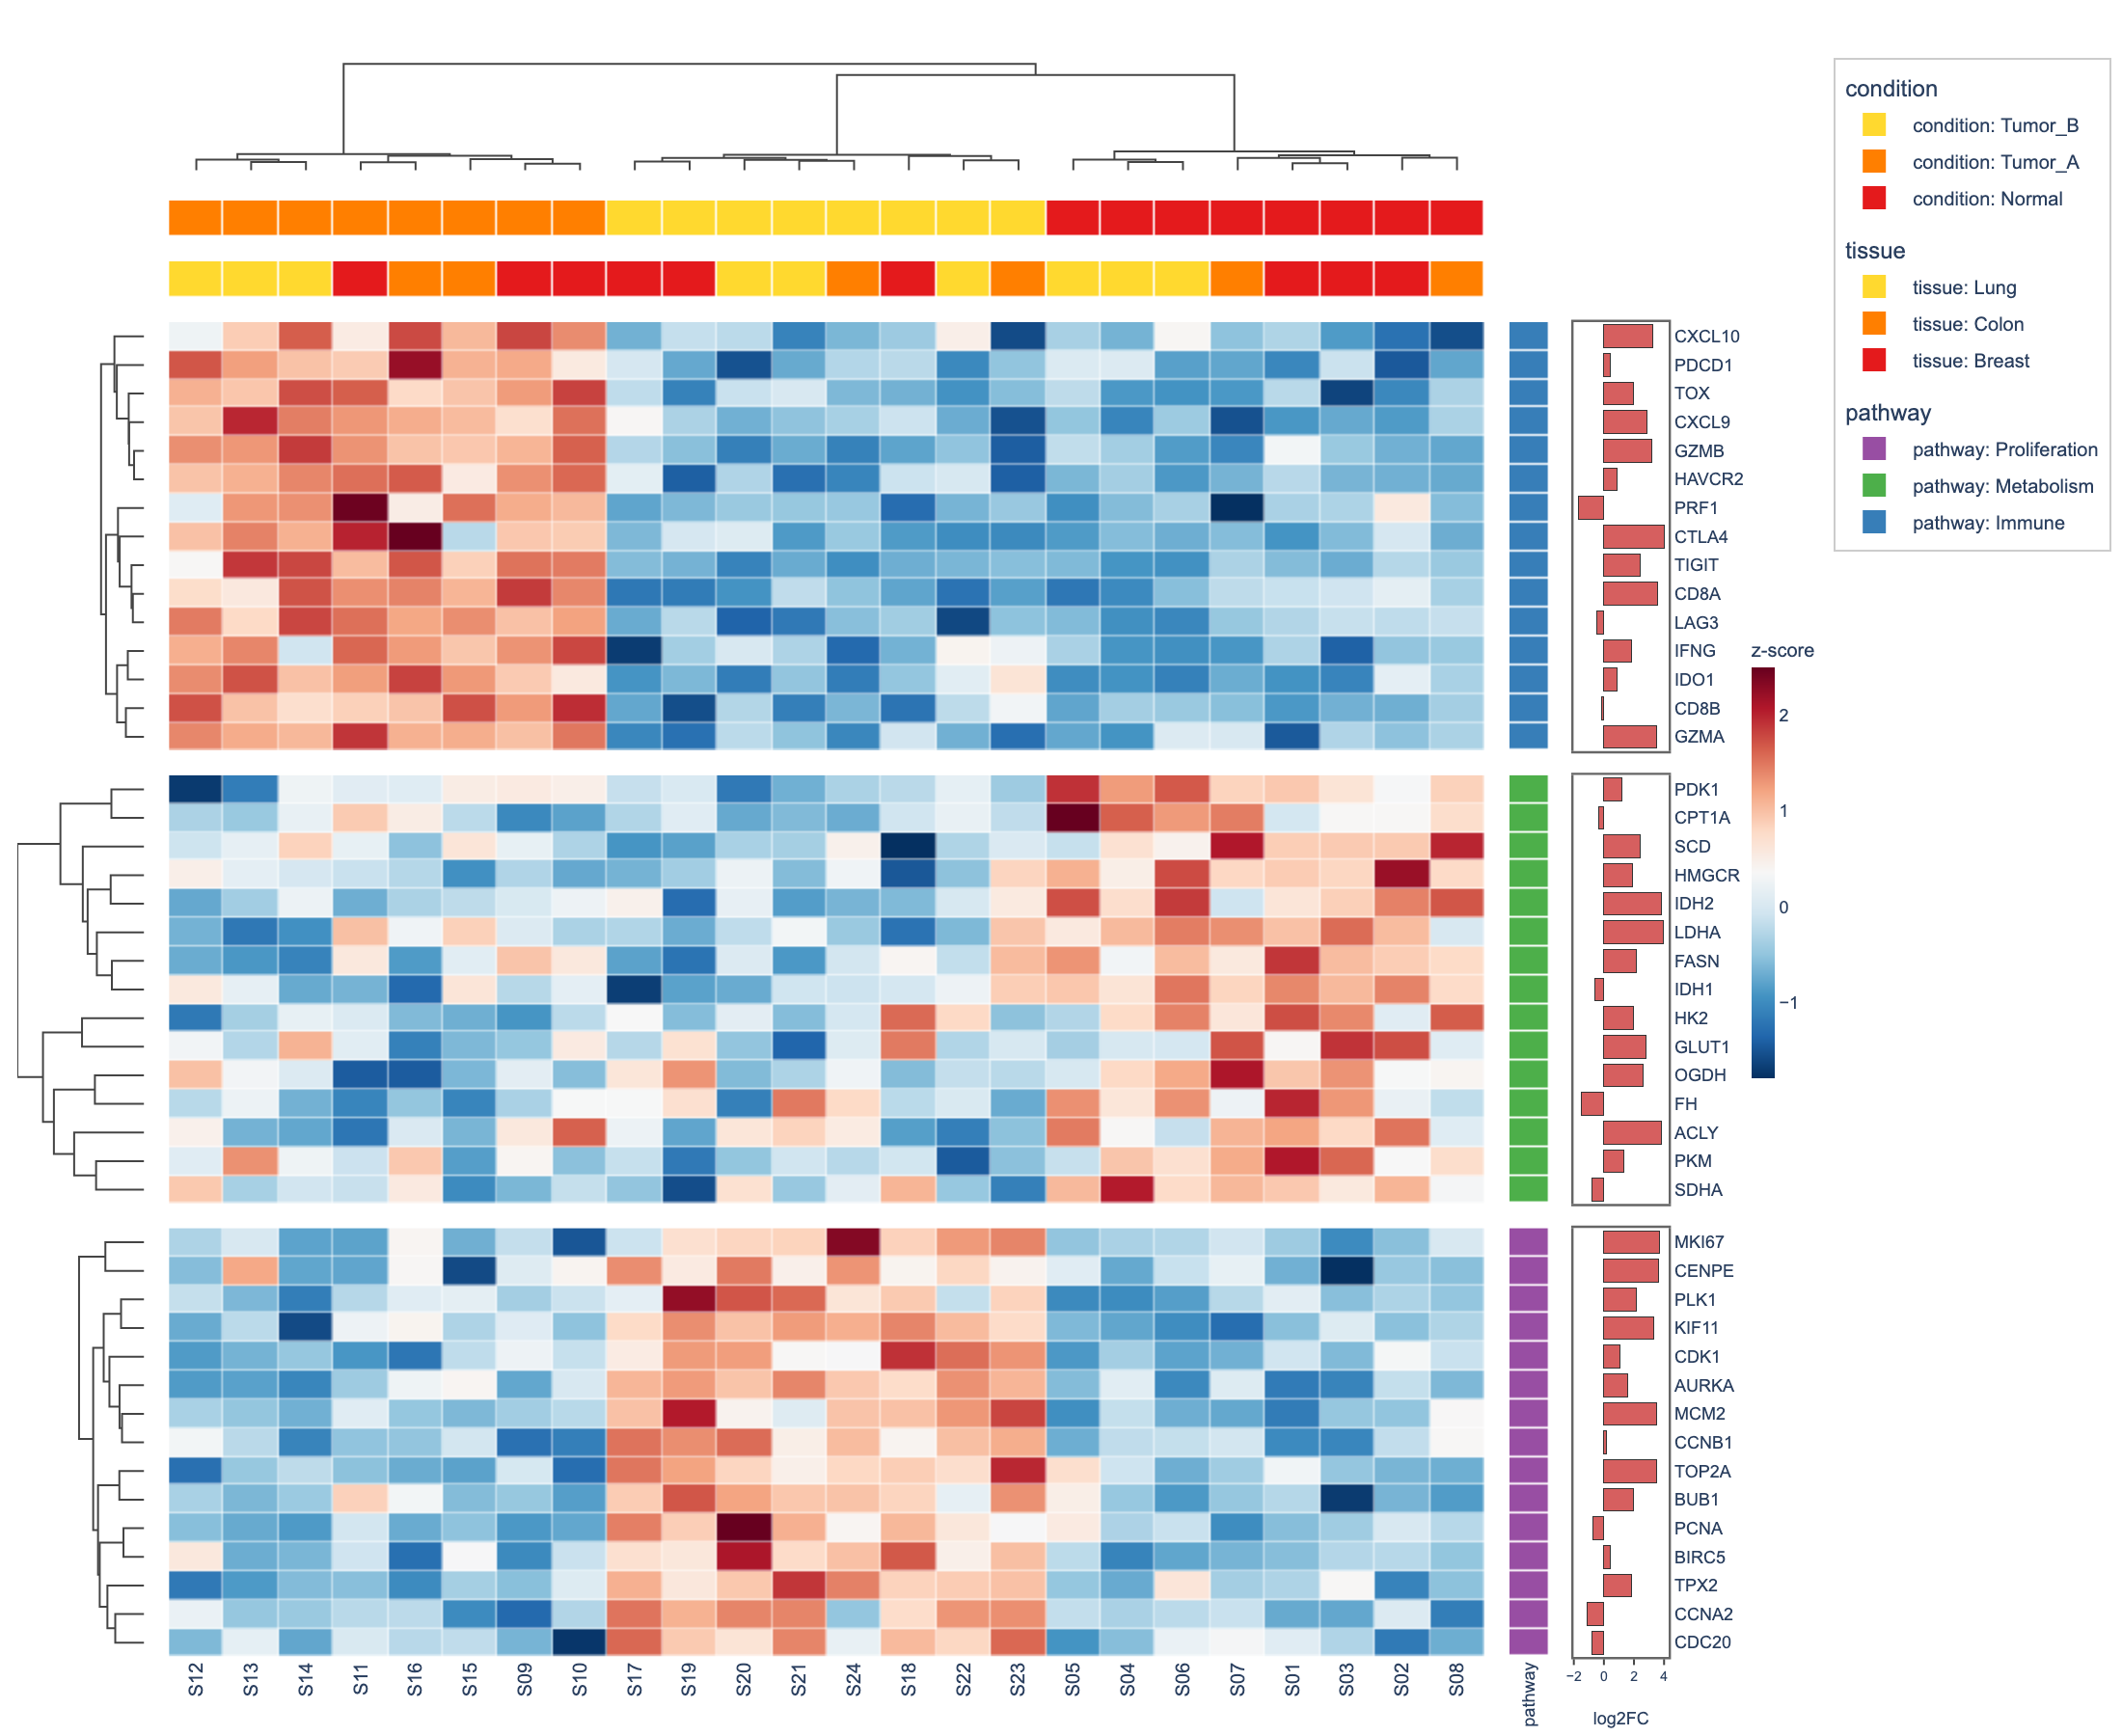

In [2]:
# Heatmap from the single DataFrame
ComplexHeatmap.from_dataframe(
    df,
    index_column="gene",
    row_annotations={
        "pathway": {},  # auto → categorical
        "log2FC": {"type": "bar", "color": "#D65F5F"},  # explicit bar
    },
    col_annotations={
        "condition": ["Normal"] * 8 + ["Tumor_A"] * 8 + ["Tumor_B"] * 8,
        "tissue": (["Breast"] * 3 + ["Lung"] * 3 + ["Colon"] * 2) * 3,
    },
    split_rows_by="pathway",
    colorscale="RdBu_r",
    normalize="row",
    name="z-score",
    cluster_metric="correlation",
    width=1100,
    height=900,
).to_plotly()

In [3]:
# ---------- 2. DNA Methylation (Epigenomics) ----------
#
# Single DataFrame: probe_id | cpg_context | gene_region | N1 … N10 | T1 … T10
# Beta values 0–1, hyper/hypomethylation in tumors.

rng2 = np.random.default_rng(2025)

n_cpg, n_meth = 40, 20
cpg_ids = [f"cg{rng2.integers(10000000, 99999999)}" for _ in range(n_cpg)]
meth_cols = [f"N{i + 1}" for i in range(10)] + [f"T{i + 1}" for i in range(10)]

beta = rng2.beta(3, 3, size=(n_cpg, n_meth))
beta[:14, 10:] = np.clip(beta[:14, 10:] + 0.35, 0, 1)  # hyper in tumor
beta[30:, 10:] = np.clip(beta[30:, 10:] - 0.30, 0, 1)  # hypo in tumor

# ── Build ONE flat DataFrame ──
df2 = pd.DataFrame(beta, columns=meth_cols)
df2.insert(0, "probe_id", cpg_ids)
df2.insert(1, "cpg_context", rng2.choice(["Island", "Shore", "Shelf", "Open Sea"], n_cpg, p=[0.35, 0.25, 0.2, 0.2]))
df2.insert(
    2, "gene_region", rng2.choice(["Promoter", "Gene Body", "3'UTR", "Intergenic"], n_cpg, p=[0.4, 0.3, 0.1, 0.2])
)

print(f"Shape: {df2.shape}")
df2.head(3)

Shape: (40, 23)


,probe_id,cpg_context,gene_region,N1,N2,...,T6,T7,T8,T9,T10
0,cg50272573,Open Sea,Gene Body,0.408268,0.260563,...,1.000000,1.000000,0.922224,1.000000,1.000000
1,cg99501201,Island,Intergenic,0.843295,0.518104,...,0.812072,0.749551,0.865973,0.989974,0.638138
2,cg99332408,Open Sea,3'UTR,0.545081,0.806894,...,0.605065,0.924103,0.693854,1.000000,0.498430


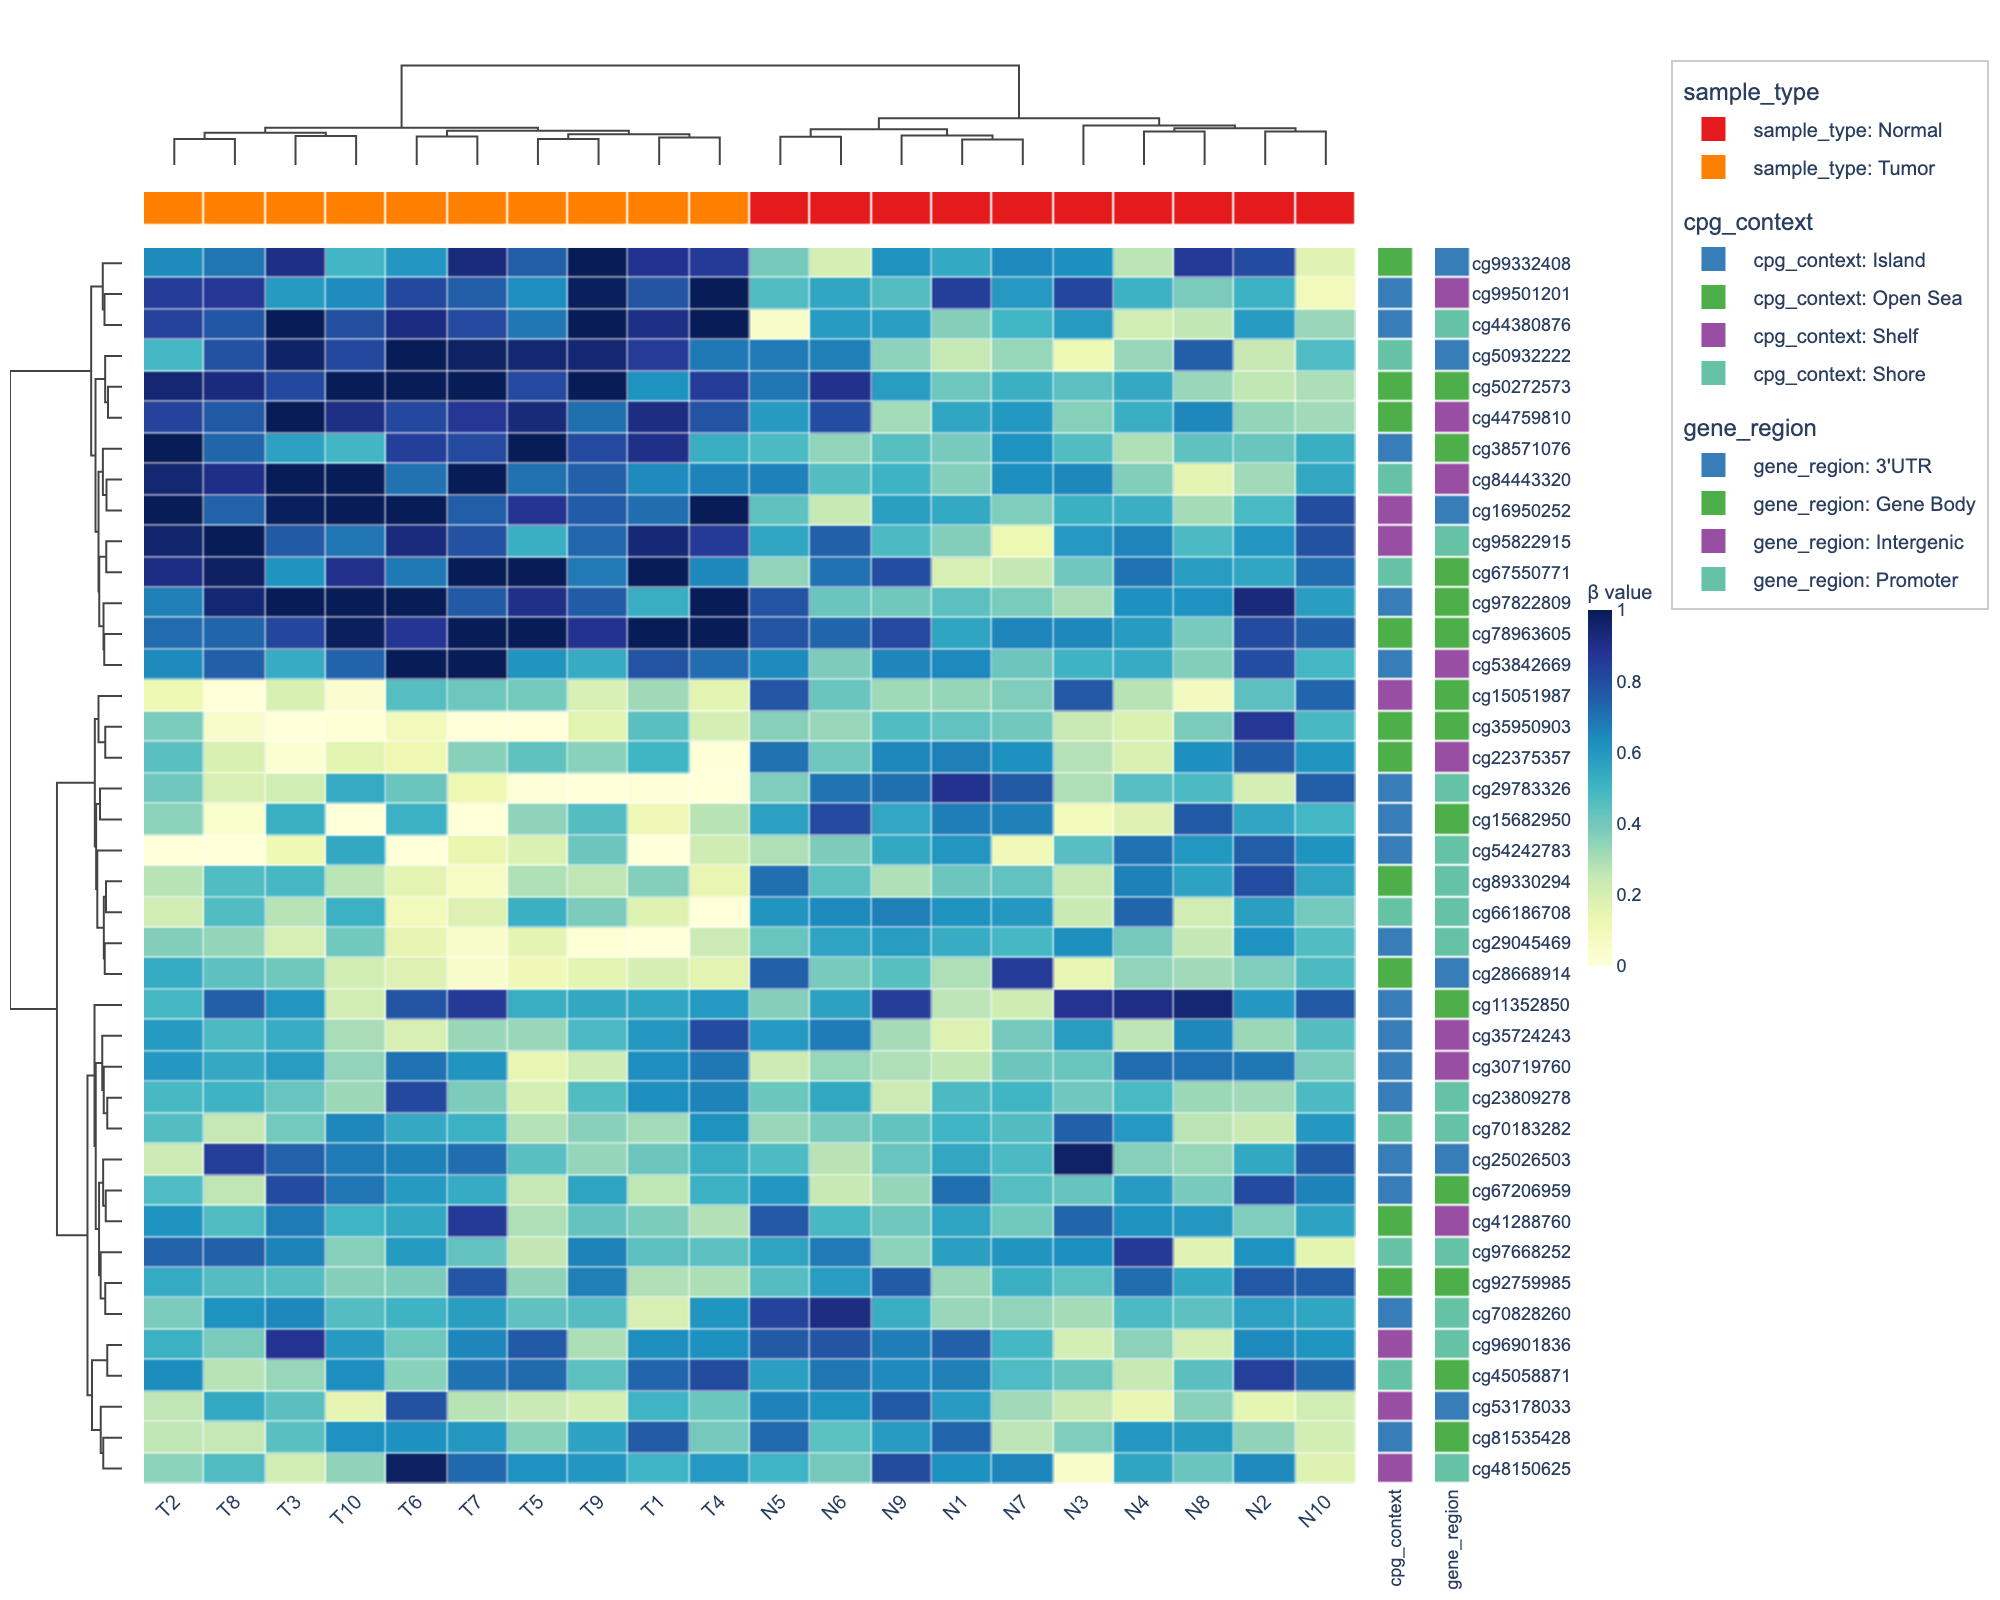

In [4]:
ComplexHeatmap.from_dataframe(
    df2,
    index_column="probe_id",
    row_annotations=["cpg_context", "gene_region"],  # auto-detect both as categorical
    col_annotations={
        "sample_type": ["Normal"] * 10 + ["Tumor"] * 10,
    },
    colorscale="YlGnBu",
    normalize="none",
    name="\u03b2 value",
    cluster_metric="euclidean",
    width=1000,
    height=800,
).to_plotly()

In [5]:
# ---------- 3. Quantitative Proteomics (Mass Spectrometry) ----------
#
# Single DataFrame: protein | complex | DMSO_HeLa_1 … Carf_MCF_3
# Log2 intensities, split by protein complex.

rng3 = np.random.default_rng(2026)

proteasome = ["PSMA1", "PSMA2", "PSMB1", "PSMB5", "PSMC1", "PSMD1", "PSMD2", "PSMD4"]
ribosome = ["RPL5", "RPL11", "RPS3", "RPS6", "RPS14", "RPL23", "RPL26", "RPS27A"]
spliceosome = ["SF3B1", "U2AF1", "SRSF2", "PRPF8", "SNRNP200", "DDX5", "HNRNPA1", "HNRNPC"]
all_proteins = proteasome + ribosome + spliceosome
n_prot = len(all_proteins)

drugs = ["DMSO"] * 6 + ["Bortezomib"] * 6 + ["Carfilzomib"] * 6
cell_lines = (["HeLa"] * 3 + ["MCF7"] * 3) * 3
prot_cols = [f"{d[:4]}_{c[:3]}_{r + 1}" for d, c, r in zip(drugs, cell_lines, list(range(3)) * 6)]

log2_int = rng3.normal(25, 1.5, (n_prot, 18))
log2_int[:8, 6:] -= 3.0  # proteasome down with inhibitors
log2_int[8:16, 6:] += 1.0  # ribosome compensatory up

# ── Build ONE flat DataFrame ──
df3 = pd.DataFrame(log2_int, columns=prot_cols)
df3.insert(0, "protein", all_proteins)
df3.insert(1, "complex", ["Proteasome"] * 8 + ["Ribosome"] * 8 + ["Spliceosome"] * 8)

print(f"Shape: {df3.shape}")
df3.head(3)

Shape: (24, 20)


,protein,complex,DMSO_HeL_1,DMSO_HeL_2,DMSO_HeL_3,...,Carf_HeL_2,Carf_HeL_3,Carf_MCF_1,Carf_MCF_2,Carf_MCF_3
0,PSMA1,Proteasome,23.810316,25.360857,22.155510,...,21.871785,22.241374,21.078972,21.394375,22.822390
1,PSMA2,Proteasome,24.804276,22.938361,24.284082,...,24.027187,23.250884,23.706575,20.671700,23.026833
2,PSMB1,Proteasome,24.221480,24.313922,25.759806,...,26.726362,24.427620,23.240660,21.004267,23.491728


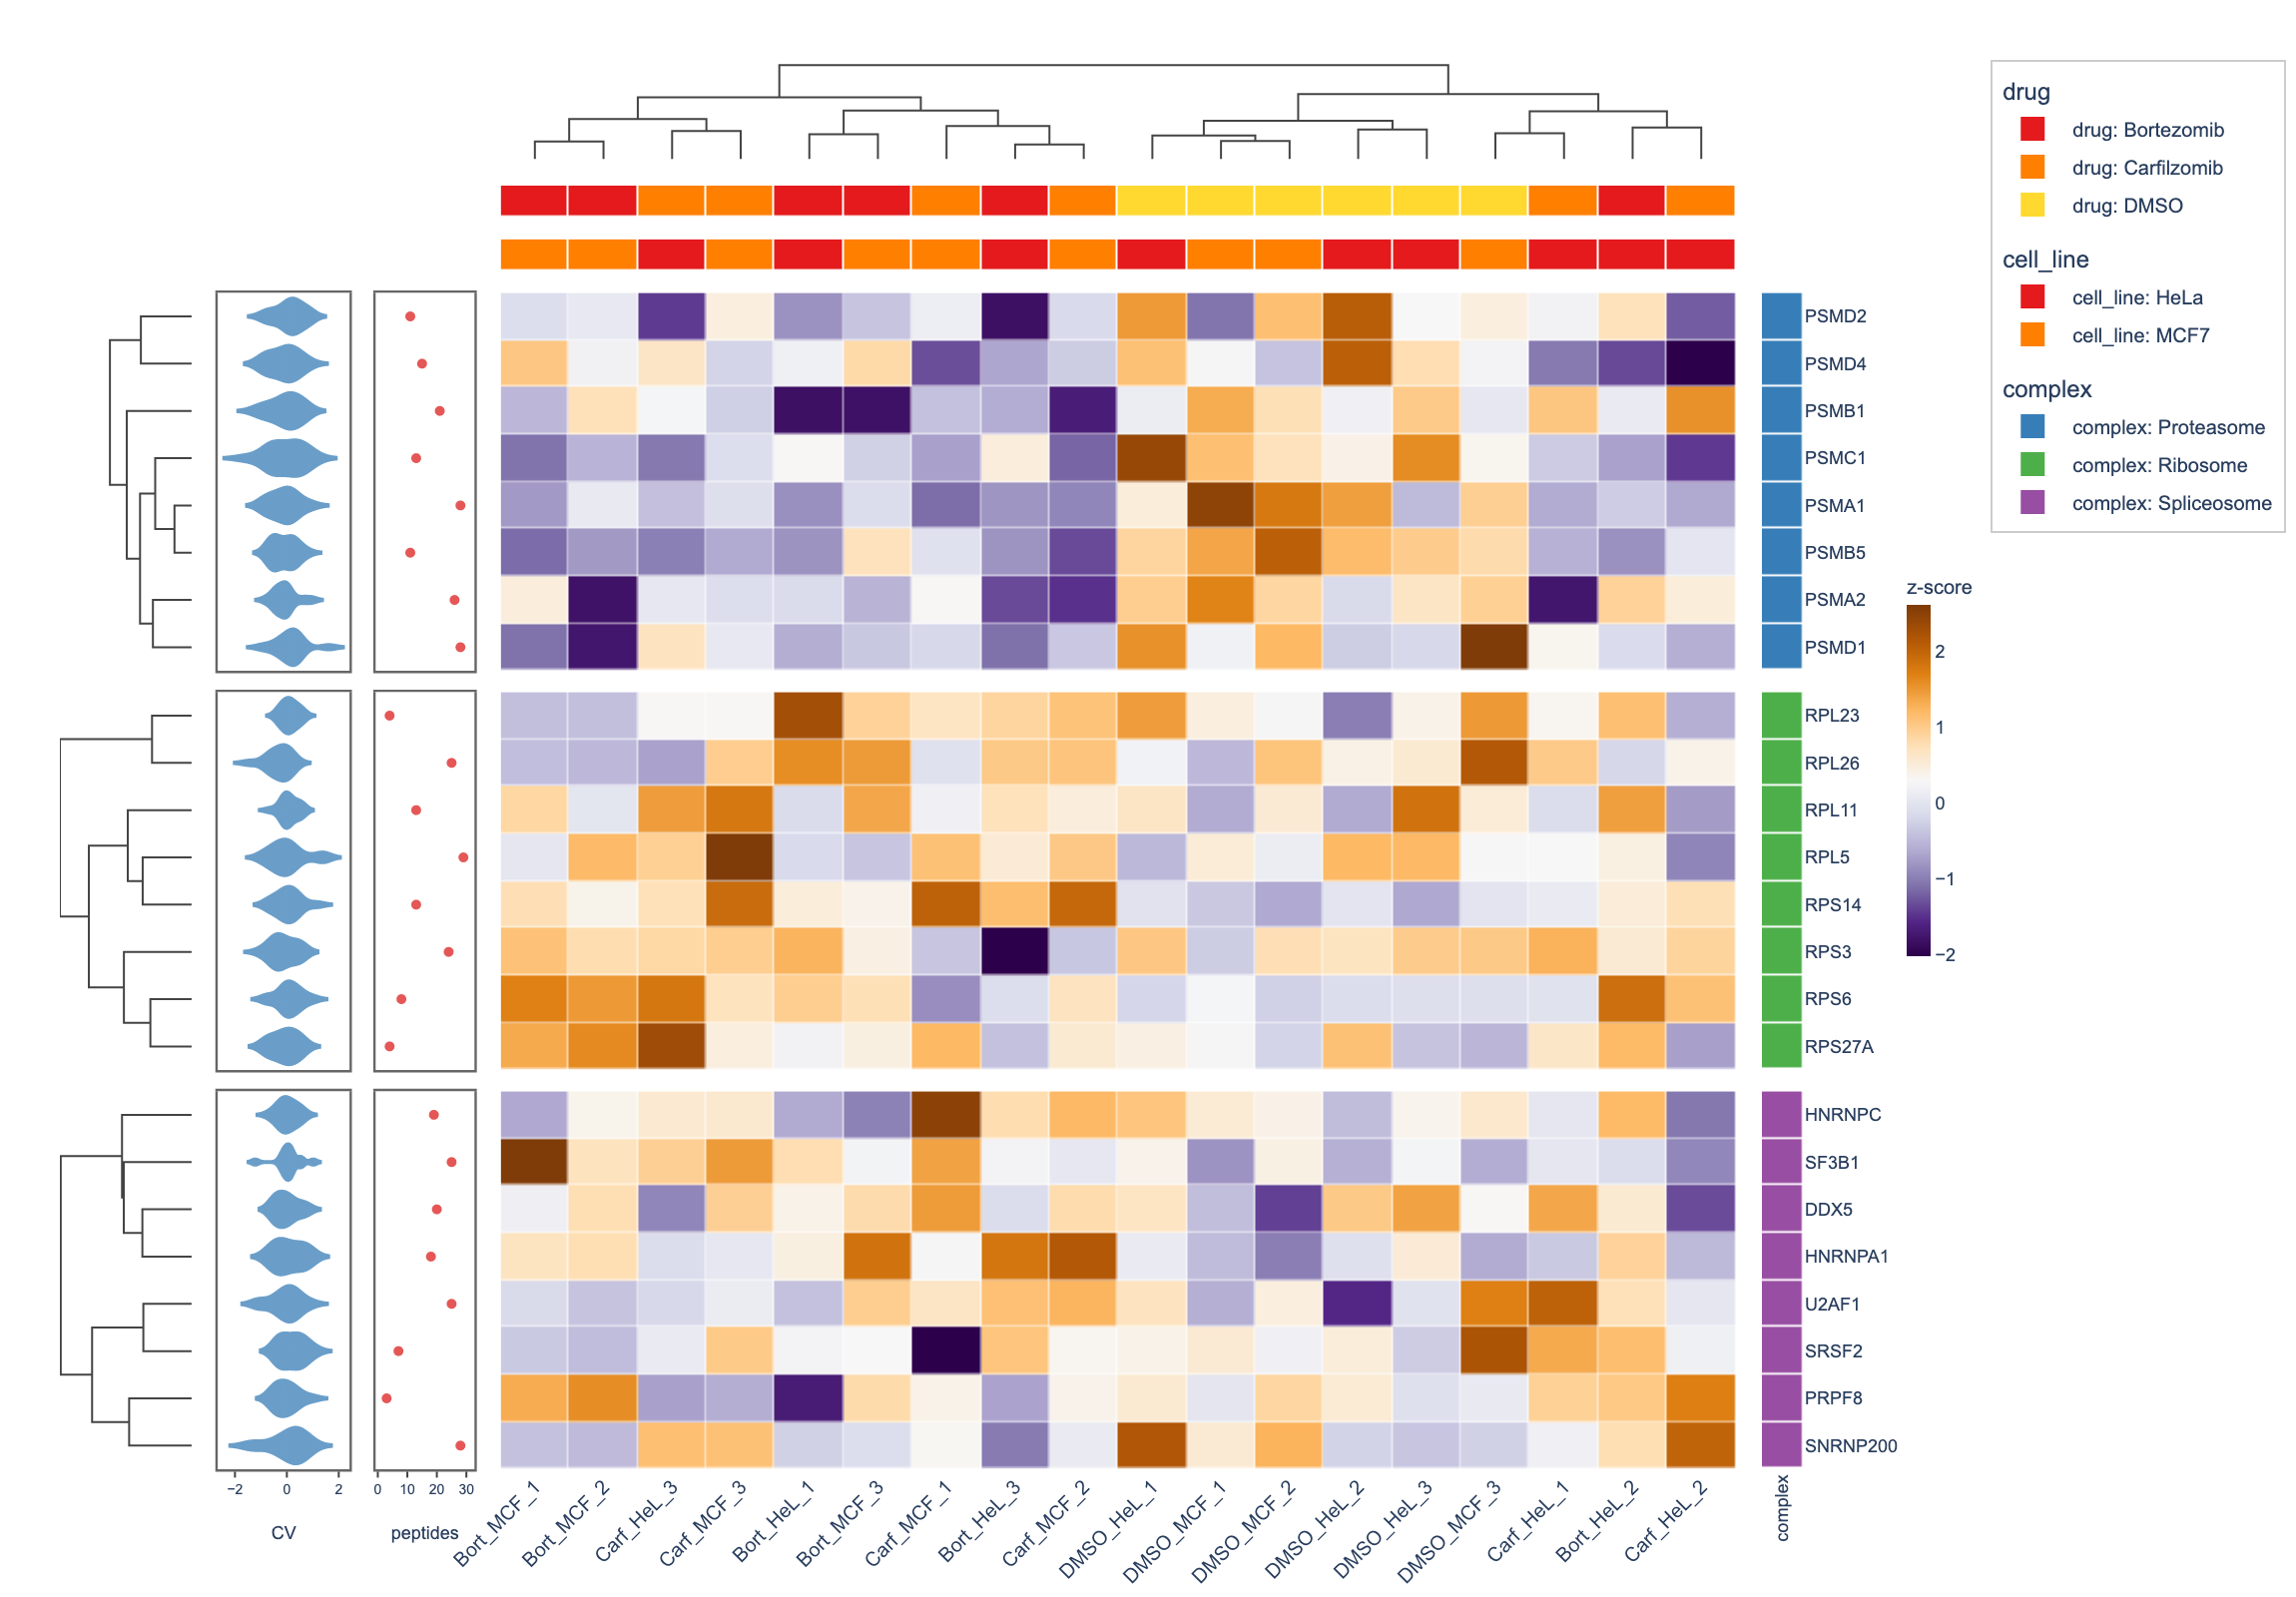

In [6]:
# Rich annotations: violin (replicate CV) + scatter (peptide count) on the left
# Start from the SAME df3 — extract matrix, build HeatmapAnnotation manually.

from plotly_complexheatmap import ComplexHeatmap, HeatmapAnnotation

# Extract heatmap matrix from the flat DataFrame
matrix = df3.set_index("protein").drop(columns=["complex"])

# Simulated additional per-protein data (would come from the same experiment)
violin_reps = rng3.normal(0, 0.5, (n_prot, 15))  # 15 technical replicates
peptide_count = rng3.integers(3, 30, n_prot).astype(float)  # unique peptides

# Left: violin (replicate variability) + scatter (peptide count)
left_ha = HeatmapAnnotation(
    CV={"values": violin_reps, "type": "violin", "color": "#6A9EC9"},
    peptides={"values": peptide_count, "type": "scatter", "color": "#E45756", "marker_size": 5},
    which="row",
)
# Top: sample metadata
top_ha = HeatmapAnnotation(drug=drugs, cell_line=cell_lines)
# Right: complex (from DF column)
right_ha = HeatmapAnnotation(complex=df3["complex"].tolist(), which="row")

ComplexHeatmap(
    matrix,
    top_annotation=top_ha,
    left_annotation=left_ha,
    right_annotation=right_ha,
    split_rows_by="complex",
    colorscale="PuOr_r",
    normalize="row",
    name="z-score",
    cluster_metric="correlation",
    width=1150,
    height=800,
).to_plotly()

In [7]:
# ---------- 4. Single-Cell Marker Genes (scRNA-seq) ----------
#
# Single DataFrame: marker | cell_type | CD4_T … Platelet
# Mean expression per cluster. No clustering — biological order preserved.

rng4 = np.random.default_rng(2027)

cluster_markers = {
    "CD4 T": ["IL7R", "CD4", "TCF7", "LEF1"],
    "CD8 T": ["CD8A", "CD8B", "GZMK", "NKG7"],
    "NK": ["GNLY", "NKG7", "KLRD1", "KLRB1"],
    "B cell": ["MS4A1", "CD79A", "CD79B", "PAX5"],
    "Monocyte": ["CD14", "LYZ", "S100A8", "S100A9"],
    "DC": ["FCER1A", "CD1C", "CLEC10A", "HLA-DQA1"],
    "Platelet": ["PPBP", "PF4", "GP9", "ITGA2B"],
}
clusters = list(cluster_markers.keys())
all_markers = [g for genes in cluster_markers.values() for g in genes]
n_markers, n_clusters = len(all_markers), len(clusters)

mean_expr = rng4.uniform(0.1, 0.8, (n_markers, n_clusters))
idx = 0
for ci, (ctype, markers) in enumerate(cluster_markers.items()):
    for mi in range(len(markers)):
        mean_expr[idx + mi, ci] = rng4.uniform(3.0, 5.5)
        if ctype in ["CD4 T", "CD8 T"]:
            other = 1 - ci if ci <= 1 else ci
            mean_expr[idx + mi, other] += rng4.uniform(0.5, 1.5)
    idx += len(markers)

# ── Build ONE flat DataFrame ──
df4 = pd.DataFrame(mean_expr, columns=clusters)
df4.insert(0, "marker", all_markers)
df4.insert(1, "cell_type", [c for c, m in cluster_markers.items() for _ in m])

print(f"Shape: {df4.shape}")
df4.head(3)

Shape: (28, 9)


,marker,cell_type,CD4 T,CD8 T,NK,B cell,Monocyte,DC,Platelet
0,IL7R,CD4 T,3.404497,1.270024,0.157764,0.448531,0.414122,0.593800,0.308452
1,CD4,CD4 T,4.641041,1.120844,0.162893,0.106258,0.367596,0.727872,0.120250
2,TCF7,CD4 T,4.954780,1.177635,0.606488,0.228596,0.510998,0.601450,0.736355


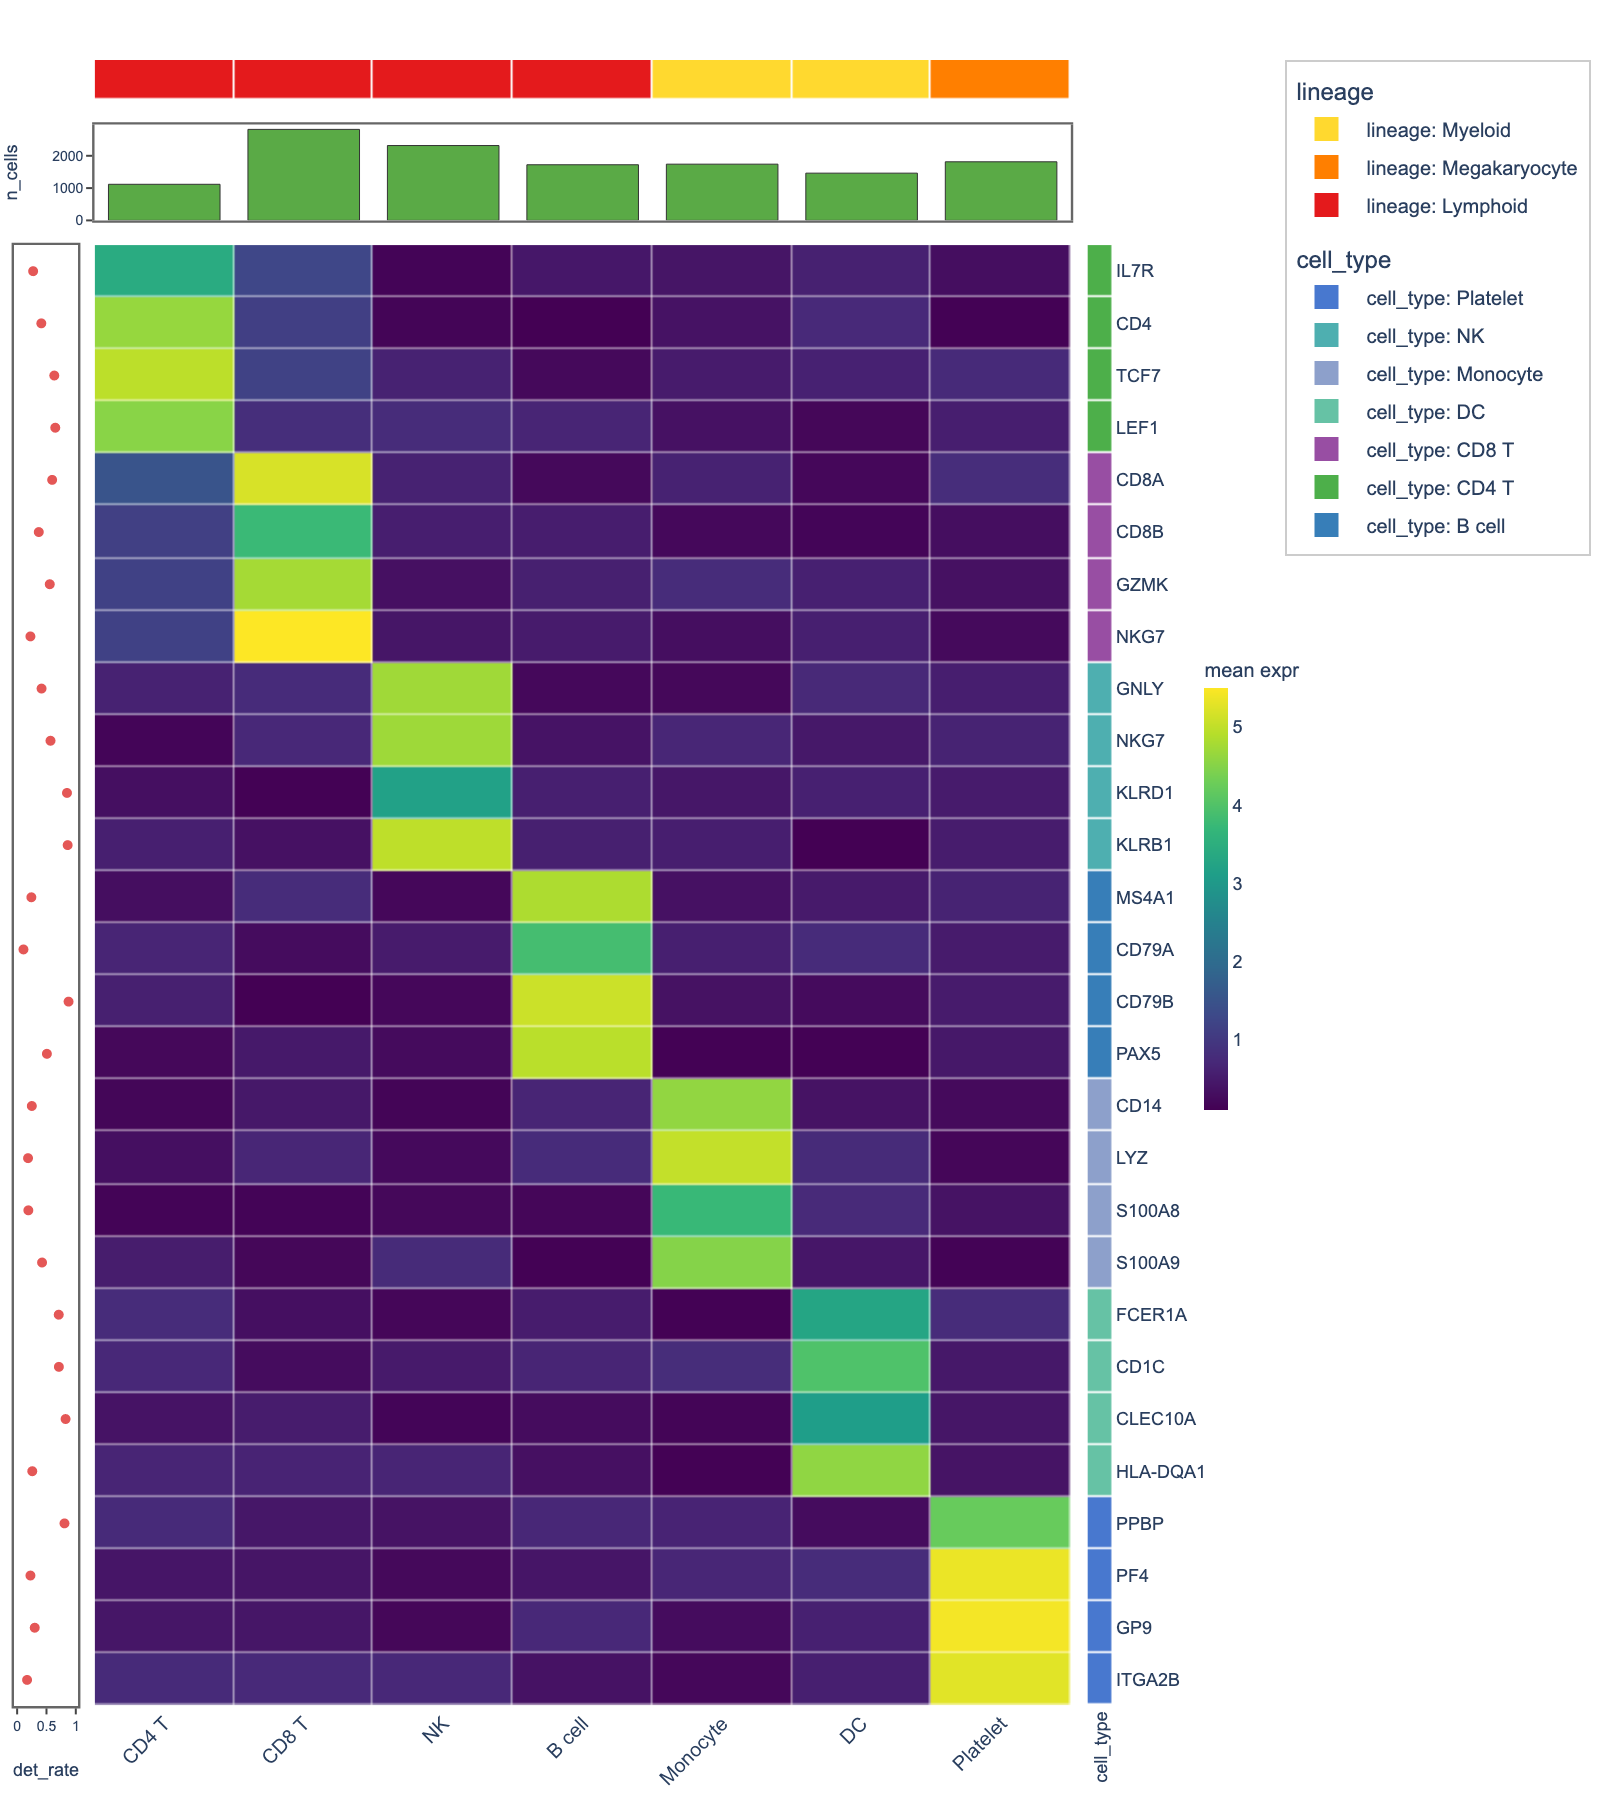

In [8]:
# Rich annotations: scatter (detection rate) on the left
# Start from the SAME df4 — extract matrix, add scatter annotation.

lineage_map = {
    "CD4 T": "Lymphoid",
    "CD8 T": "Lymphoid",
    "NK": "Lymphoid",
    "B cell": "Lymphoid",
    "Monocyte": "Myeloid",
    "DC": "Myeloid",
    "Platelet": "Megakaryocyte",
}

matrix4 = df4.set_index("marker").drop(columns=["cell_type"])

# Simulated detection rate: fraction of cells expressing each marker (0–1)
detection_rate = rng4.uniform(0.1, 0.95, n_markers)

# Left: scatter (detection rate)
left_ha4 = HeatmapAnnotation(
    det_rate={"values": detection_rate, "type": "scatter", "color": "#E45756", "marker_size": 5},
    which="row",
)
# Top: lineage + cell count bar
top_ha4 = HeatmapAnnotation(
    lineage=[lineage_map[c] for c in clusters],
    n_cells={"values": rng4.integers(200, 3000, n_clusters).astype(float), "type": "bar", "color": "#5AAA46"},
)
# Right: cell type (from DF column)
right_ha4 = HeatmapAnnotation(cell_type=df4["cell_type"].tolist(), which="row")

ComplexHeatmap(
    matrix4,
    top_annotation=top_ha4,
    left_annotation=left_ha4,
    right_annotation=right_ha4,
    cluster_rows=False,
    cluster_cols=False,
    colorscale="Viridis",
    normalize="none",
    name="mean expr",
    width=800,
    height=900,
).to_plotly()

In [9]:
# ---------- 5. Clinical Metabolomics ----------
#
# Single DataFrame: metabolite | pathway | met_class | P01 … P30
# Concentration data with disease-specific signatures.

rng5 = np.random.default_rng(2028)

aa = [
    "Alanine",
    "Glutamine",
    "Glutamate",
    "Leucine",
    "Isoleucine",
    "Valine",
    "Phenylalanine",
    "Tyrosine",
    "Tryptophan",
    "Serine",
]
lipids = [
    "Palmitate",
    "Stearate",
    "Oleate",
    "Linoleate",
    "Arachidonate",
    "Sphingomyelin",
    "Ceramide",
    "LysoPC(16:0)",
    "LysoPC(18:1)",
    "PC(34:2)",
]
energy = [
    "Glucose",
    "Lactate",
    "Pyruvate",
    "Citrate",
    "Succinate",
    "Fumarate",
    "Malate",
    "3-HB",
    "Acetoacetate",
    "Creatinine",
]
all_met = aa + lipids + energy
n_met, n_pat = len(all_met), 30
pat_cols = [f"P{i + 1:02d}" for i in range(n_pat)]

conc = rng5.standard_normal((n_met, n_pat)) * 0.6
conc[4:7, 10:20] += 2.5  # BCAAs up in diabetes
conc[20, 10:20] += 3.0  # glucose up in diabetes
conc[21, 10:20] += 2.0  # lactate up in diabetes
conc[10:20, 20:] -= 1.8  # lipids down in cancer
conc[27:29, 20:] += 2.5  # ketone bodies up in cancer
conc[:10, :10] += 0.5  # amino acids balanced in healthy

# ── Build ONE flat DataFrame ──
df5 = pd.DataFrame(conc, columns=pat_cols)
df5.insert(0, "metabolite", all_met)
df5.insert(1, "pathway", ["Amino Acid"] * 10 + ["Lipid"] * 10 + ["Energy"] * 10)
df5.insert(
    2,
    "met_class",
    ["Essential AA"] * 4
    + ["BCAA"] * 3
    + ["Aromatic"] * 3
    + ["Fatty Acid"] * 5
    + ["Sphingolipid"] * 2
    + ["Phospholipid"] * 3
    + ["Glycolysis"] * 3
    + ["TCA Cycle"] * 4
    + ["Ketone"] * 2
    + ["Other"] * 1,
)

print(f"Shape: {df5.shape}")
df5.head(3)

Shape: (30, 33)


,metabolite,pathway,met_class,P01,P02,...,P26,P27,P28,P29,P30
0,Alanine,Amino Acid,Essential AA,0.356196,1.203328,...,-0.625525,0.773585,1.282994,0.144430,1.162707
1,Glutamine,Amino Acid,Essential AA,-0.744104,0.718084,...,-0.592461,0.296269,-0.346749,0.550223,-0.251126
2,Glutamate,Amino Acid,Essential AA,-0.285576,0.164567,...,0.072483,0.289846,-0.352854,0.313216,-0.846863


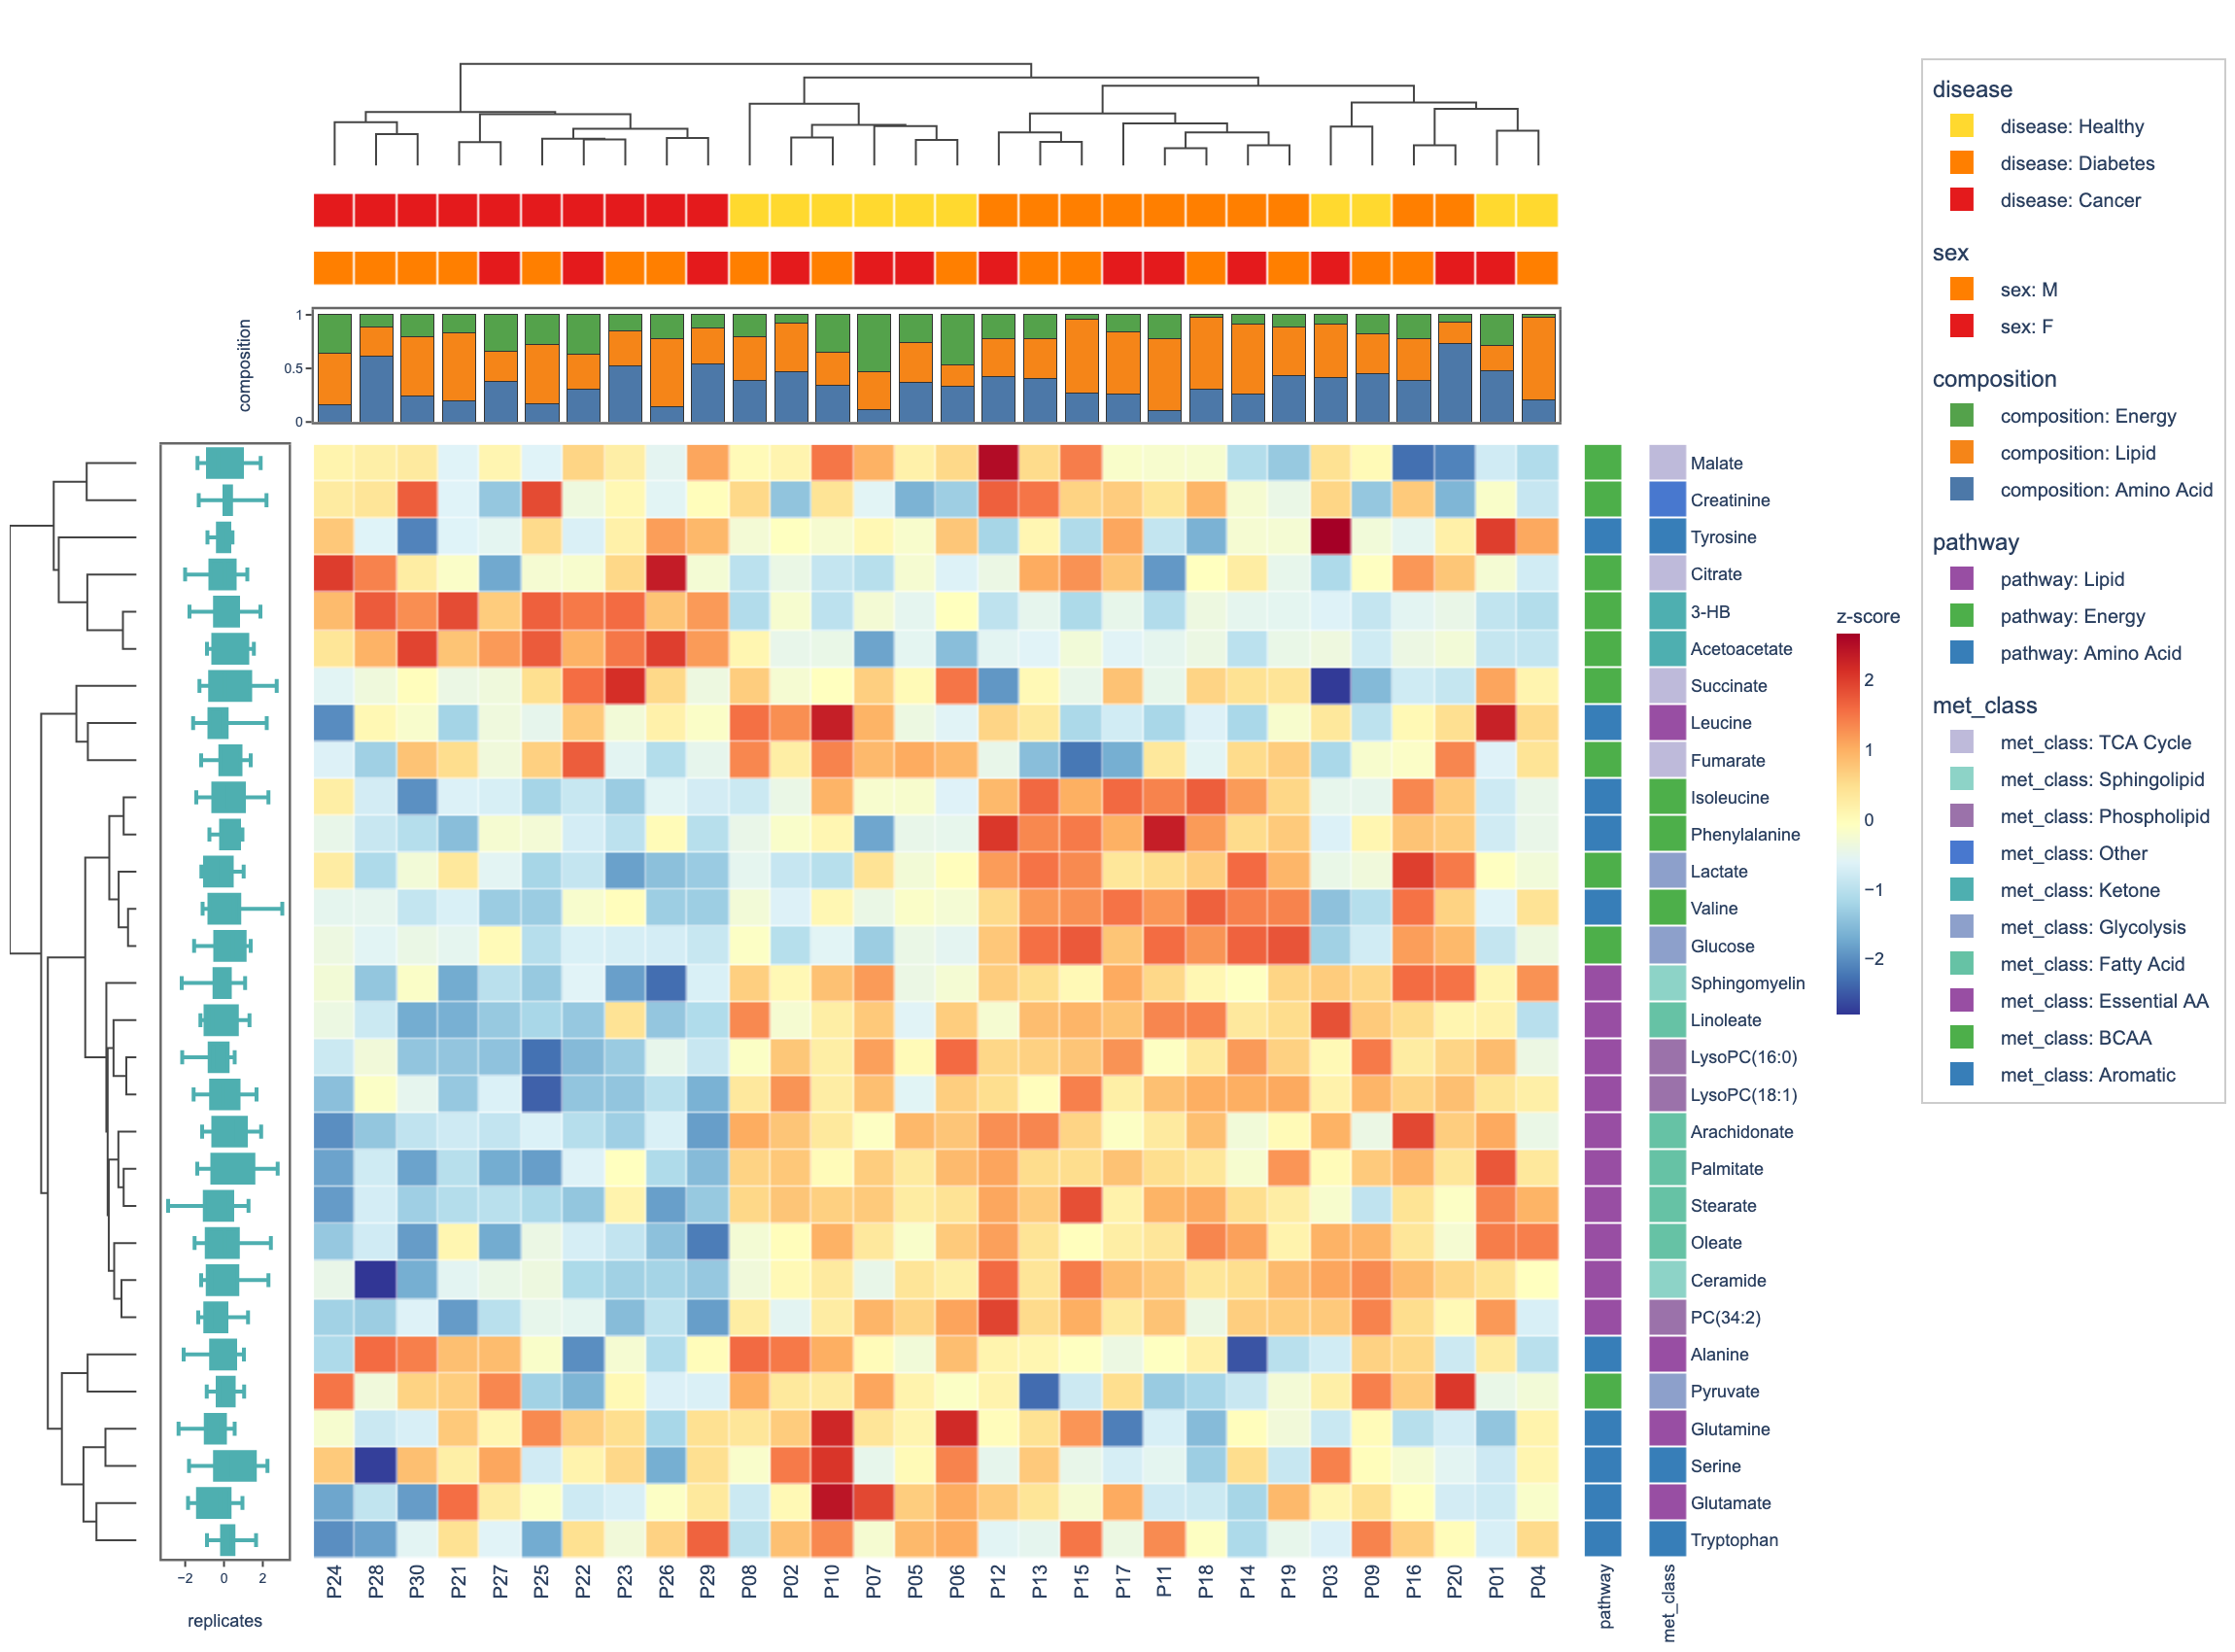

In [10]:
# Rich annotations: stacked bar (top, sample composition) + box (left, replicates)
# Start from the SAME df5 — extract matrix, build rich annotations.

matrix5 = df5.set_index("metabolite").drop(columns=["pathway", "met_class"])

# Simulated additional data
box_reps = rng5.standard_normal((n_met, 10))  # 10 technical replicates per metabolite
pathway_comp = rng5.dirichlet([3, 4, 2], n_pat)  # pathway proportions per patient

# Top: disease + stacked bar (metabolite class composition per patient)
top_ha5 = HeatmapAnnotation(
    disease=["Healthy"] * 10 + ["Diabetes"] * 10 + ["Cancer"] * 10,
    sex=rng5.choice(["M", "F"], n_pat).tolist(),
    composition={
        "values": pathway_comp,
        "type": "stacked_bar",
        "stack_names": ["Amino Acid", "Lipid", "Energy"],
        "colors": ["#4C78A8", "#F58518", "#54A24B"],
    },
)
# Left: box (technical replicate distribution)
left_ha5 = HeatmapAnnotation(
    replicates={"values": box_reps, "type": "box", "color": "#4EAFB0"},
    which="row",
)
# Right: pathway + met_class (from DF columns)
right_ha5 = HeatmapAnnotation(
    pathway=df5["pathway"].tolist(),
    met_class=df5["met_class"].tolist(),
    which="row",
)

ComplexHeatmap(
    matrix5,
    top_annotation=top_ha5,
    left_annotation=left_ha5,
    right_annotation=right_ha5,
    colorscale="RdYlBu_r",
    normalize="row",
    name="z-score",
    cluster_method="complete",
    cluster_metric="correlation",
    width=1150,
    height=850,
).to_plotly()